In [1]:
from gensim.models import Word2Vec, FastText
import parsivar
import json
import pickle
import itertools
import functools
import seaborn as sns
import random
import numpy as np
import pandas as pd
import editdistance
from polyleven import levenshtein

In [2]:
normalizer = parsivar.Normalizer()
tokenizer = parsivar.Tokenizer()

# load data

In [2]:
f = open("test.txt", "r", encoding='utf-8')
number_of_chars = len(f.read())
print(f'{number_of_chars} characters')
f.close()
f = open("test.txt", "r", encoding='utf-8')
number_of_lines = len(f.readlines())
print(f'{number_of_lines} lines')
f.close()

237915404 characters
2106953 lines


In [ ]:
def get_sentences():
    sentences = []
    with open("test.txt", "r", encoding='utf-8') as t:
        while True:
            line = t.readline()
            if line == "":
                break
            sentences.append(tokenizer.tokenize_words(line))
    return sentences

In [4]:
%%time
sentences = get_sentences()
# print(len(sentences))
# 4GB of RAM

Wall time: 20.7 s


# fastText model

In [2]:
FastText_model = FastText.load("FastTextModel")
# 3.5GB RAM

In [ ]:
%%time
FastText_model = FastText(vector_size=300, window=5, min_count=1, sentences=sentences, epochs=5)

In [ ]:
FastText_model.wv.most_similar(FastText_model.wv['شاه'])

In [ ]:
FastText_model.save("FastTextModel")

# Word2Vec model

In [3]:
word2vec_model = Word2Vec.load("Word2VecModel")
# 1GB RAM

In [ ]:
%%time
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=1, sentences=sentences, epochs=5)

In [41]:
word2vec_model.wv.most_similar(word2vec_model.wv['مرد'], topn=10)

[('مرد', 1.0),
 ('زن', 0.6828464865684509),
 ('شوهر', 0.6612272262573242),
 ('مردی', 0.6603354811668396),
 ('دختر', 0.6036628484725952),
 ('دختری', 0.5984135270118713),
 ('میانسال', 0.5959803462028503),
 ('شوهری', 0.5932475328445435),
 ('پیرزن', 0.5812994837760925),
 ('پیرمرد', 0.5786240100860596)]

In [34]:
word2vec_model.wv.distance("شاه", "ملکه")

0.524875283241272

In [ ]:
word2vec_model.save("Word2VecModel")

# load Ngram Model

In [4]:
def words_to_tuple(words, model):
    return tuple([model.wv.key_to_index[words[i]] for i in range(len(words))])

# seems some of the words in the text file is not present in model key_to_index
def build_ngrams(n):
    ngram_counts = {}
    with open("test.txt", "r", encoding='utf-8') as t:
        while True:
            line = t.readline()
            if line == "":
                break
            words = tokenizer.tokenize_words(line)
            for i in range(max(len(words)-n+1, 0)):
                try:
#                     pre_words_indices = tuple([word2vec_model.wv.key_to_index[words[i+j]] for j in range(n)])
                    pre_words_indices = words_to_tuple(words[i:i+n], word2vec_model)
                    if pre_words_indices in ngram_counts:
                        ngram_counts[pre_words_indices] += 1
                    else:
                        ngram_counts[pre_words_indices] = 1
                except:
                    pass
    return ngram_counts

In [5]:
%%time
word_counts = build_ngrams(1)
word_counts["all"] = sum(word_counts.values())
print("words counts: ", word_counts["all"])
# 100MB of RAM
biword_counts = build_ngrams(2)
biword_counts["all"] = sum(biword_counts.values())
print("biword counts: ", biword_counts["all"])

# 700MB of RAM
threeword_counts = build_ngrams(3)
threeword_counts["all"] = sum(threeword_counts.values())
print("threeword counts: ", threeword_counts["all"])
# 1.6GB of RAM
# fourword_counts = build_ngrams(4)
# fourword_counts["all"] = sum(fourword_counts.values())
# 3.5GB of RAM

words counts:  42671360
biword counts:  34459834
threeword counts:  19255364
Wall time: 4min 2s


In [187]:
with open('word counts.json', 'wb') as f:
    pickle.dump(word_counts, f)
with open('bi-grams.json', 'wb') as f:
    pickle.dump(biword_counts, f)
with open('three-grams.json', 'wb') as f:
    pickle.dump(threeword_counts, f)
with open('four-grams.json', 'wb') as f:
    pickle.dump(fourword_counts, f)

In [18]:
print(f'words:       {len(word_counts)}')
print(f'bi-grams:    {len(biword_counts)}')
print(f'three-grams: {len(threeword_counts)}')
print(f'four-grams:  {len(fourword_counts)}')

words:       347680
bi-grams:    6764724
three-grams: 20208193
four-grams:  29157652


In [5]:
with open('word counts.json', 'rb') as f:
    word_counts = pickle.load(f)
    f.close()
with open('bi-grams.json', 'rb') as f:
    biword_counts = pickle.load(f)
    f.close()
with open('three-grams.json', 'rb') as f:
    threeword_counts = pickle.load(f)
    f.close()
# with open('four-grams.json', 'rb') as f:
#     fourword_counts = pickle.load(f)
#     f.close()

# define spell checker

In [6]:
character_neighbors = {
    "ض" : ["ص", "ظ", "ز", "ذ"],
    "ص" : ["ض", "ث"],
    "ث" : ["ص", "ق"],
    "ق" : ["ف", "ث", "غ"],
    "ف" : ["ق", "غ"],
    "غ" : ["ف", "ه", "ق"],
    "ع" : ["غ", "ه"],
    "ه" : ["ع", "خ", "ح"],
    "خ" : ["ه", "ح"],
    "ح" : ["خ", "ج", "ه"],
    "ج" : ["ح", "چ"],
    "چ" : ["ج", "پ"],
    "پ" : ["چ", "ب"],
    "ش" : ["س"],
    "س" : ["ش", "ی"],
    "ی" : ["س", "ب"],
    "ب" : ["ی", "ل"],
    "ل" : ["ب", "ا", "آ"],
    "ا" : ["ل", "ت"],
    "آ" : ["ل", "ت"],
    "ت" : ["ا", "ن", "ط", "آ"],
    "ن" : ["ت", "م"],
    "م" : ["ن", "ک"],
    "ک" : ["م", "گ"],
    "گ" : ["ک"],
    "ظ" : ["ط", "ض", "ز", "ذ"],
    "ط" : ["ظ", "ز", "ت"],
    "ز" : ["ط", "ض", "ر", "ذ"],
    "ژ" : ["ط", "ر"],
    "ر" : ["ز", "ذ"],
    "ذ" : ["ر", "ض", "د", "ذ"],
    "د" : ["ذ", "ی"],
    "و" : ["د"],
}

In [7]:
replaceble_characters = list(character_neighbors.keys())

In [8]:
def edit_distance(word, proposed_word, m, n, distance=0, max_distance=2, changes=[]):
    if m == 0:
        return n
    if n == 0:
        return m
    if word[m-1] == proposed_word[n-1]:
        return edit_distance(word, proposed_word, m-1, n-1, distance, max_distance)
    else:
        if distance == max_distance:
            return max_distance+1
        return 1+(min(edit_distance(word, proposed_word, m,   n-1, distance+1, max_distance), 
                      edit_distance(word, proposed_word, m-1, n,   distance+1, max_distance),
                      edit_distance(word, proposed_word, m-1, n-1, distance+1, max_distance)))

In [34]:
a = "qewsdfavvasd"
b = "asvdawqdqweqf"


In [35]:
%%time
for i in range(100000):
    editdistance.eval(a, b)

Wall time: 127 ms


In [39]:
%%time
for i in range(100000):
    edit_distance(a, b, len(a), len(b))

Wall time: 480 ms


In [17]:
%%time
for i in range(100000):
    levenshtein(a, b)

8
Wall time: 24.9 ms


In [98]:
sorted([1, 4, 2])

[1, 2, 4]

In [329]:
class spell_checker:
    def __init__(self, model, word_counts, biword_counts, threeword_counts, fourword_counts, 
                 candidate_count_tresh=50, candidate_sim_tresh = 0.6, ngram_weights=[1, 1, 1], 
                 max_editdistance=2, close_extra_char_penalty = 0.1, far_extra_char_penalty = 0.001, 
                 missed_char_penalty = 0.01, close_replace_char_penalty = 0.1, far_replace_char_penalty = 0.001):
        self.model = model
        self.word_counts = word_counts
        self.biword_counts = biword_counts
        self.threeword_counts = threeword_counts
        self.fourword_counts = fourword_counts
        self.candidate_count_tresh = candidate_count_tresh
        self.candidate_sim_tresh = candidate_sim_tresh
        
        self.ngram_weights = np.array(ngram_weights)
        self.max_editdistance = max_editdistance
        
        self.close_extra_char_penalty = close_extra_char_penalty
        self.far_extra_char_penalty = far_extra_char_penalty
        self.missed_char_penalty = missed_char_penalty
#         self.close_extra_char_penalty = 0.1
        self.close_replace_char_penalty = close_replace_char_penalty
        self.far_replace_char_penalty = far_replace_char_penalty
        
    
    def cal_proposed_word_penalty(self, word, proposed_word, m=0, n=0):
        distance = levenshtein(word, proposed_word)
        
        return 0.01**distance
        
        if m == len(word):
            if n == len(proposed_word):
                return 1
            x = [self.close_extra_char_penalty if proposed_word[i] in  character_neighbors.get(proposed_word[i-1], []) else 
                 self.far_extra_char_penalty for i in range(n, len(proposed_word))]
            return np.prod(x)

        if n == len(proposed_word):
#             if m == len(word):
#                 return 1
            return self.missed_char_penalty**(len(word)-m)

        if word[m] == proposed_word[n]:
            return self.cal_proposed_word_penalty(word, proposed_word, m+1, n+1)

        neighbors = character_neighbors.get(proposed_word[n], [])

        if (n >= 1 and proposed_word[n-1] in neighbors) or (n <= len(proposed_word)-2 and proposed_word[n+1] in neighbors):
            addition_cost = self.close_extra_char_penalty
        else:
            addition_cost = self.far_extra_char_penalty

        if word[m] in neighbors:
            replace_cost = self.close_replace_char_penalty
        else:
            replace_cost = self.far_replace_char_penalty

        return (max(addition_cost*self.cal_proposed_word_penalty(word, proposed_word, m,   n+1),     # delete letter
                    self.missed_char_penalty*self.cal_proposed_word_penalty(word, proposed_word, m+1, n),       # add letter
                    replace_cost* self.cal_proposed_word_penalty(word, proposed_word, m+1, n+1)))    # replace letter
    

    def cal_score(self, query_words, proposed_words):
        S0_scores = []
        S1_scores = []
        S2_scores = []
#         print(proposed_words)
        result_penalties = [self.cal_proposed_word_penalty(query_words[i], proposed_words[i]) for i in range(len(query_words))]
        for i in range(len(proposed_words)):
            # OOV penalty?
            counts = self.word_counts.get((self.model.wv.key_to_index.get(proposed_words[i], None), ), None)
            if counts is None:
                S0_scores.append(1/self.word_counts["all"]*result_penalties[i])
            else:
                S0_scores.append(counts/self.word_counts["all"]*result_penalties[i])
            if i >= 1:
                key = (self.model.wv.key_to_index.get(proposed_words[i-1], None), self.model.wv.key_to_index.get(proposed_words[i], None))
                counts = self.biword_counts.get(key, 0)
                if counts == 0:
                    S1_scores.append(1/self.biword_counts["all"]*result_penalties[i])
                else:
                    key = (self.model.wv.key_to_index.get(proposed_words[i-1], None), )
                    S1_scores.append(counts/self.word_counts[key]*result_penalties[i])
                    
            if i >= 2:
                key = (self.model.wv.key_to_index.get(proposed_words[i-2], None), self.model.wv.key_to_index.get(proposed_words[i-1], None), self.model.wv.key_to_index.get(proposed_words[i], None))
                counts = self.threeword_counts.get(key, None)
                if counts is None:
                    S2_scores.append(1/self.threeword_counts["all"]*result_penalties[i])
                else:
                    try:
                        key2 = (self.model.wv.key_to_index.get(proposed_words[i-2], None), self.model.wv.key_to_index.get(proposed_words[i-1], None))
                        S2_scores.append(counts/self.biword_counts[key2]*result_penalties[i])
                    except Exception as e:
                        print(key)
                        print(key2)
                        print(key in self.threeword_counts)
                        print(key2 in self.biword_counts)
                        raise Exception()


    #     res = functools.reduce(lambda a,b: a*b, [1/5 if proposed_words[i]!=query_words[i] else 1 for i in range(len(query_words))])
    #     return (weights[0]*sum(S0_scores)+weights[1]*sum(S1_scores)+weights[2]*sum(S2_scores))*res
        
        score = np.dot(self.ngram_weights, np.array([sum(x) for x in [S0_scores, S1_scores, S2_scores]])) / sum(self.ngram_weights)
        return score
#         return (self.ngram_weights[0]*sum(S0_scores)+self.ngram_weights[1]*sum(S1_scores)+self.ngram_weights[2]*sum(S2_scores))   
    
    def check_if_need_replacement(self, query_words, context):
        res = []
        for i in range(len(query_words)):
#             if query_words[i] not in self.model.wv.key_to_index or self.model.wv.cosine_similarities(
#                                self.model.wv[query_words[i]], context) < self.candidate_sim_tresh:
            
            if query_words[i] not in self.model.wv.key_to_index or self.model.wv.cosine_similarities(
                               self.model.wv[query_words[i]], context) < self.candidate_sim_tresh:
                res.append(True)
                continue
#             if i > 0 :
#                 key = (self.model.wv.key_to_index.get(query_words[i-1], None), self.model.wv.key_to_index.get(query_words[i], None))
#                 counts = self.biword_counts.get(key, 0)
#                 if counts < 5:
#                     res.append(True)
#                     continue
            res.append(False)
        return res
            
    
    def cal_word_candidates(self, query_words, save_time=False):
        res = []
        
        context = np.average(np.array([self.model.wv[word] for word in query_words if word in self.model.wv.key_to_index]), axis=0)
        context = np.expand_dims(context, axis=0)
        word_need_replacement = self.check_if_need_replacement(query_words, context)
        #         print(context.size)
        for i in range(len(query_words)):
#             print(query_words[i], )
            if word_need_replacement[i]:
                res.append([x for x in self.model.wv.key_to_index if 
                            levenshtein(x, query_words[i], self.max_editdistance) <= self.max_editdistance and
                            self.word_counts.get((self.model.wv.key_to_index[x], ), 1 ) > self.candidate_count_tresh])
            
#                 res.append(sorted([x for x in self.model.wv.key_to_index if 
#                             levenshtein(x, query_words[i], self.max_editdistance) <= self.max_editdistance and
#                             self.word_counts.get((self.model.wv.key_to_index[x], ), 1 ) > self.candidate_count_tresh], 
#                                  key=lambda x: self.model.wv.cosine_similarities(self.model.wv[x], context),  reverse=True)[:100])
            else:
                res.append([query_words[i]])
            if save_time and np.prod([len(x) for x in res]) > 10000:
                return None
        return list(itertools.product(*res))
    
    def correct_answere(self, query, rank=-1, save_time=False):
#         query_words = tokenizer.tokenize_words(normalizer.normalize(query))
        query_words = tokenizer.tokenize_words(query)
        
        candidates = self.cal_word_candidates(query_words, save_time=save_time)
        if candidates is None:
            return ""
        results_and_scores = [(candidate, self.cal_score(query_words, candidate)) for candidate in candidates]
        results_and_scores = sorted(results_and_scores, key=lambda x: x[1], reverse=True)
        if rank == -1:
            return " ".join(results_and_scores[0][0])
        else:
            return [(" ".join(results_and_scores[i][0]), results_and_scores[i][1]) for i in range(rank)]
            
#         return results_and_scores[:10]

In [330]:
SP = spell_checker(word2vec_model, word_counts, biword_counts, threeword_counts, None, 
                   candidate_count_tresh=100,  candidate_sim_tresh = 0.4, ngram_weights=[1, 10, 100],
                   max_editdistance=3, close_extra_char_penalty=0.1, far_extra_char_penalty=0.001, 
                   missed_char_penalty=0.001, close_replace_char_penalty=0.1, far_replace_char_penalty=0.001)

In [335]:
%%time
SP.correct_answere("باید توجه دشته باشیم", rank=10)

Wall time: 118 ms


[('باید توجه داشته باشیم', 0.2977210763607179),
 ('باید توجه نداشته باشیم', 0.06041236593443446),
 ('باید توجه مدظله باشیم', 0.0027719899527999694),
 ('باید توجه شاهد باشیم', 0.002769831031957271),
 ('باید توجه نگفته باشیم', 0.002254549435374231),
 ('باید توجه ندیده باشیم', 0.0019740491549214536),
 ('باید توجه چیده باشیم', 0.001964985765517681),
 ('باید توجه دیم باشیم', 0.0019561741369881654),
 ('باید توجه دوتا باشیم', 0.0019117749071733165),
 ('باید توجه آگاه باشیم', 0.001859055357996368)]

In [337]:
%%time
word = "ی ادامه داد غپو"
query_words = tokenizer.tokenize_words(word)
a = SP.cal_word_candidates(query_words, save_time=True)
# len(a)

Wall time: 222 ms


# Test model

In [306]:
def test_spell_checker(spell_checker, df, save_time):
    corrects = 0
    empties = 1
    answeres = []
    for i in range(len(df)):
        correct_word, misspelled_word = df.loc[i, ["correct word", "misspelled word"]]
        try:
#             print(correct_word, "---", misspelled_word)
            corrected_word = spell_checker.correct_answere(misspelled_word, save_time=save_time)
            if correct_word == "":
                empties += 1
        except Exception as e:
            print(correct_word)
            print(misspelled_word)
            print(len(correct_word), len(misspelled_word))
            raise Exception()
        answeres.append(corrected_word)
        if corrected_word == correct_word:
            corrects += 1
#         print("*****")
    return corrects/len(df), corrects/(len(df)-empties), answeres

# test on bigrams

In [82]:
homophonic_df=pd.read_csv("homophonics biword.csv", index_col=[0])
random_error_df=pd.read_csv("random bigram.csv", index_col=[0])
random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes,none word
2657,همین رابطه,همین ظرابطنه,2.0,1.0,0.0,"[[], [2, 2]]",True
1388,وی بیان,بیان,2.0,1.0,0.0,"[[1, 1], []]",False
1608,فدراسیون فوتبال,فراسون فوتبال,2.0,1.0,0.0,"[[1, 1], []]",True
2858,بشکه نفت,بشکه هفظت,2.0,1.0,0.0,"[[], [0, 2]]",True
524,چه اندازه,چم اچدازه,2.0,2.0,0.0,"[[0], [0]]",True
1775,اعلام کرده‌اند,اعلام کرذه‌اند,1.0,1.0,1.0,"[[], [0]]",True
1427,کمیته ملی,کمیته کملی,1.0,1.0,1.0,"[[], [2]]",True
1843,فراهم کنیم,فرهک گنیم,3.0,2.0,1.0,"[[1, 0], [0]]",True
2162,قیمت کالاهای,قیمت کلالاهای,1.0,1.0,1.0,"[[], [2]]",True
875,چگونه می‌توان,چگونه ب‌توات,3.0,1.0,1.0,"[[], [1, 0, 0]]",True


In [234]:
%%time
# sample_df = random_error_df.query("`total edit distance`==1").sample(200).reset_index(drop=True)
sample_df = random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

0.805
Wall time: 46.7 s


In [233]:
%%time
# sample_df = homophonic_df.query("`total edit distance`==1").sample(200).reset_index(drop=True)
sample_df = homophonic_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

0.7090501121914734
Wall time: 1min 46s


In [235]:
%%time
# sample_df = random_error_df.query("`total edit distance`==2").sample(200).reset_index(drop=True)
sample_df = random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

0.5722639933166249
Wall time: 2min 18s


In [238]:
%%time
# sample_df = homophonic_df.query("`total edit distance`==2").sample(200).reset_index(drop=True)
sample_df = homophonic_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

0.5516162669447341
Wall time: 2min 56s


In [313]:
%%time
# sample_df = random_error_df.query("`total edit distance`==3").sample(200).reset_index(drop=True)
sample_df = random_error_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

In [ ]:
%%time
# sample_df = homophonic_df.query("`total edit distance`==3").sample(200).reset_index(drop=True)
sample_df = homophonic_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, answeres = test_spell_checker(SP, sample_df)
print(accuracy)

# test on threegrams

In [339]:
# homophonic_df=pd.read_csv("homophonics threeword.csv", index_col=[0])
random_error_df=pd.read_csv("random threegram.csv", index_col=[0])
random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes
1214,عضو هیات رییسه,عضو هیات یسسه,2.0,1.0,1.0,"[[], [], [1, 0]]"
2445,ستاد کل نیروهای,ستد کل آنیروهای,2.0,2.0,0.0,"[[1], [], [2]]"
33,احیای توافق هسته‌ای,حای توافق هسته‌ای,2.0,1.0,1.0,"[[1, 1], [], []]"
1801,چند روز بعد,چند رورز بعد,1.0,1.0,1.0,"[[], [2], []]"
2328,حفاظت محیط زیست,حفاظت نمیزط زیست,3.0,1.0,1.0,"[[], [2, 1, 2], []]"
1733,امام صادق ع,تاملم صادق ع,2.0,1.0,1.0,"[[2, 0], [], []]"
2453,ساخت هزار واحد,ساخت هزار نواد,2.0,1.0,0.0,"[[], [], [2, 1]]"
2553,باید مشخص شود,باید مشخص وذد,2.0,1.0,1.0,"[[], [], [1, 2]]"
966,سال کل کشور,شلل کل گکشور,3.0,2.0,1.0,"[[0, 0], [], [2]]"
1313,جلسه ستاد ملی,جس ستاد ملی,2.0,1.0,0.0,"[[1, 1], [], []]"


In [340]:
%%time
sample_df = random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.664440734557596 0.6666666666666666
Wall time: 56.5 s


In [341]:
%%time
sample_df = random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.39548494983277593 0.6158854166666666
Wall time: 2min 32s


In [342]:
%%time
sample_df = random_error_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.41216216216216217 0.6272493573264781
Wall time: 2min 38s


# test on fourgrams

In [82]:
# homophonic_df=pd.read_csv("homophonics threeword.csv", index_col=[0])
random_error_df=pd.read_csv("random fourgram.csv", index_col=[0])
random_error_df.sample(n=10)

,correct word,misspelled word,total edit distance,number of words with error,close change,changes
91,تیم ملی فوتبال کشورمان,تیم ملی وتبایل کشورمان,2.0,1.0,0.0,"[[], [], [1, 2], []]"
732,قرارگاه عملیاتی ستاد ملی,قرارگاه عملیاتی گدد ملی,3.0,1.0,0.0,"[[], [], [0, 1, 0], []]"
1103,داده‌های وبگاه ورلد امترز,داده‌های وبگاه وذرد امرز,3.0,2.0,1.0,"[[], [], [2, 1], [1]]"
252,افزایش قیمت کالاهای اساسی,افزایش قیمت کابلاهاس اساسی,2.0,1.0,1.0,"[[], [], [2, 0], []]"
1528,دز سوم واکسن کرونا,ز سوم اکسو کرونا,3.0,2.0,0.0,"[[1], [], [1, 0], []]"
1299,امام ج ص پیام,امام حج ث پیام,2.0,2.0,1.0,"[[], [2], [0], []]"
1340,سخنگوی وزارت امور خارجه,سخنگوی جزاضت امور خرجه,3.0,2.0,0.0,"[[], [0, 0], [], [1]]"
667,گزارش پایگاه اطلاع‌رسانی وزارت,گزارش پایگاه ازلاع‌رسانی وزارت,1.0,1.0,1.0,"[[], [], [0], []]"
2158,مدیرعامل شرکت متروی تهران,مدیرعامل شخرشکت متروی تهران,2.0,1.0,0.0,"[[], [2, 2], [], []]"
2193,زمان روی کار آمدن,زمان روی گکت آمدن,3.0,1.0,1.0,"[[], [], [2, 0, 1], []]"


In [322]:
def test_spell_checker(spell_checker, df, save_time):
    corrects = 0
    empties = 1
    answeres = []
    for i in range(len(df)):
        correct_word, misspelled_word = df.loc[i, ["correct word", "misspelled word"]]
        try:
#             print(correct_word, "---", misspelled_word)
            corrected_word = spell_checker.correct_answere(misspelled_word, save_time=save_time)
            if corrected_word == "":
                empties += 1
        except Exception as e:
            print(correct_word)
            print(misspelled_word)
            print(len(correct_word), len(misspelled_word))
            raise Exception()
        answeres.append(corrected_word)
        if corrected_word == correct_word:
            corrects += 1
#         print("*****")
    return corrects/len(df), corrects/(len(df)-empties), answeres

In [323]:
%%time
sample_df = random_error_df.query("`total edit distance`==1").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.7161936560934892 0.7295918367346939
Wall time: 1min


In [324]:
%%time
sample_df = random_error_df.query("`total edit distance`==2").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.4332220367278798 0.6883289124668435
Wall time: 2min 55s


In [338]:
%%time
sample_df = random_error_df.query("`total edit distance`==3").reset_index(drop=True)
accuracy, non_empty_accuracy, answeres = test_spell_checker(SP, sample_df, save_time=True)
print(accuracy, non_empty_accuracy)

0.4494097807757167 0.7078353253652059
Wall time: 2min 46s


# statistics

In [124]:
word2vec_model.wv.vectors.shape

(347679, 300)

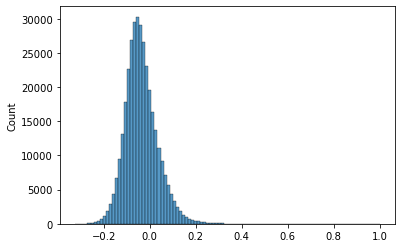

In [134]:
sns.histplot(x=word2vec_model.wv.cosine_similarities(word2vec_model.wv["سازمان"], word2vec_model.wv.vectors), bins=100);

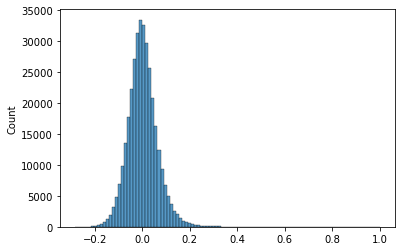

In [149]:
sns.histplot(x=word2vec_model.wv.cosine_similarities(word2vec_model.wv["غذا"], word2vec_model.wv.vectors), bins=100);

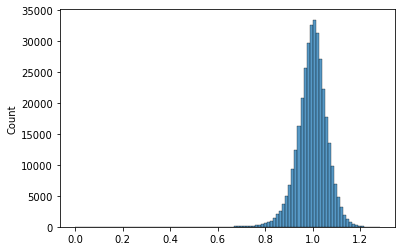

In [148]:
sns.histplot(x=word2vec_model.wv.distances("غذا", other_words=([key for key in word2vec_model.wv.key_to_index])), bins=100);

In [183]:
sum(word2vec_model.wv.distances("غذا", other_words=([key for key in word2vec_model.wv.key_to_index])) < 0.9)

20137

In [187]:
for key in word2vec_model.wv.key_to_index:
    sim = word2vec_model.wv.cosine_similarities(word2vec_model.wv["غذا"], [word2vec_model.wv[key]])
    if sim > 0.35 and sim < 0.4:
        print(key)

ملل
دارویی
شیر
خوراک
چای
تغذیه
خوراکی
داروها
سرم
گرسنگی
بسته‌بندی
مایحتاج
افطار
دستکش
خرما
غذاهای
آشپزخانه
پلاستیک
شوینده
آجیل
ضدعفونی‌کننده
لقمه
شستن
شربت
شیرخشک
میوه‌ها
سبزیجات
پودر
پز
پلاسما
پوشک
برنامه‌وبودجه
محلول
خوابیدن
کنسرو
نوشابه
دستشویی
آمپول
بستنی
صابون
نانی
سحری
شکلات
آبگوشت
مکمل‌های
قرص‌های
نوشیدنی‌های
خوشمزه
طعام
داروست
تنقلات
جیره
ساندویچ
ویتامین‌ها
بشقاب
سالاد
پخت‌وپز
دورریز
چیپس
غذا‌های
نظام‌پزشکی
سوپ
ملل‌بود
نوشیدنی‌ها
دمنوش
لذیذ
دسفرال
می‌پزند
خوراندن
دارو‌بود
غذاودارو
بپزد
می‌پزد
مقوی
چاشت
میان‌وعده
مللی
بپزند
ملل‌متحد
پریمیدون
نمی‌شویند
آدوکانوماب
سیا‌بودم
بخورین
لکت
ویسواگوارو
سه‌ربع
نصرکشور
اوقاف‌بود
آب‌و‌فاضلاب
دیگ‌دیگ
میراث‌فرهنگی‌بودید
محلی‌ترین
تهرانسره
امور‌مالیاتی
مریضامون
رسمی‌مقامات
فرآیند‌‌های
تجویز‌شده‌اما
